# Swish-based classifier using cosine-annealed LR with restarts and data augmentation
- Swish activation, 4 layers, 100 neurons per layer
- LR using cosine-annealing with restarts and cycle multiplicity of 2
- Data is augmentaed via phi rotations, and transvers and longitudinal flips
- Validation score use ensemble of 10 models weighted by loss

### Import modules

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
sys.path.append('../')
from modules.basics import *
from modules.class_basics import *

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Options

In [2]:
with open(DATA_PATH/'feats.pkl', 'rb') as fin:
    train_feats = pickle.load(fin)
    train_feats = [var for x in train_feats for var in train_feats[x]]

In [3]:
n_models = 10
patience = 2
max_epochs = 200

ensemble_size = 10
ensemble_mode = 'loss'

compile_args = {'loss':'binary_crossentropy', 'optimizer':'adam'}
train_params = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
model_params = {'version':'modelSwish', 'n_in':len(train_feats), 'compile_args':compile_args, 'mode':'classifier'}

print ("\nTraining on", len(train_feats), "features:", [var for var in train_feats])


Training on 31 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [4]:
train_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'train.hdf5', "r+"), rot_mult=8)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 32


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


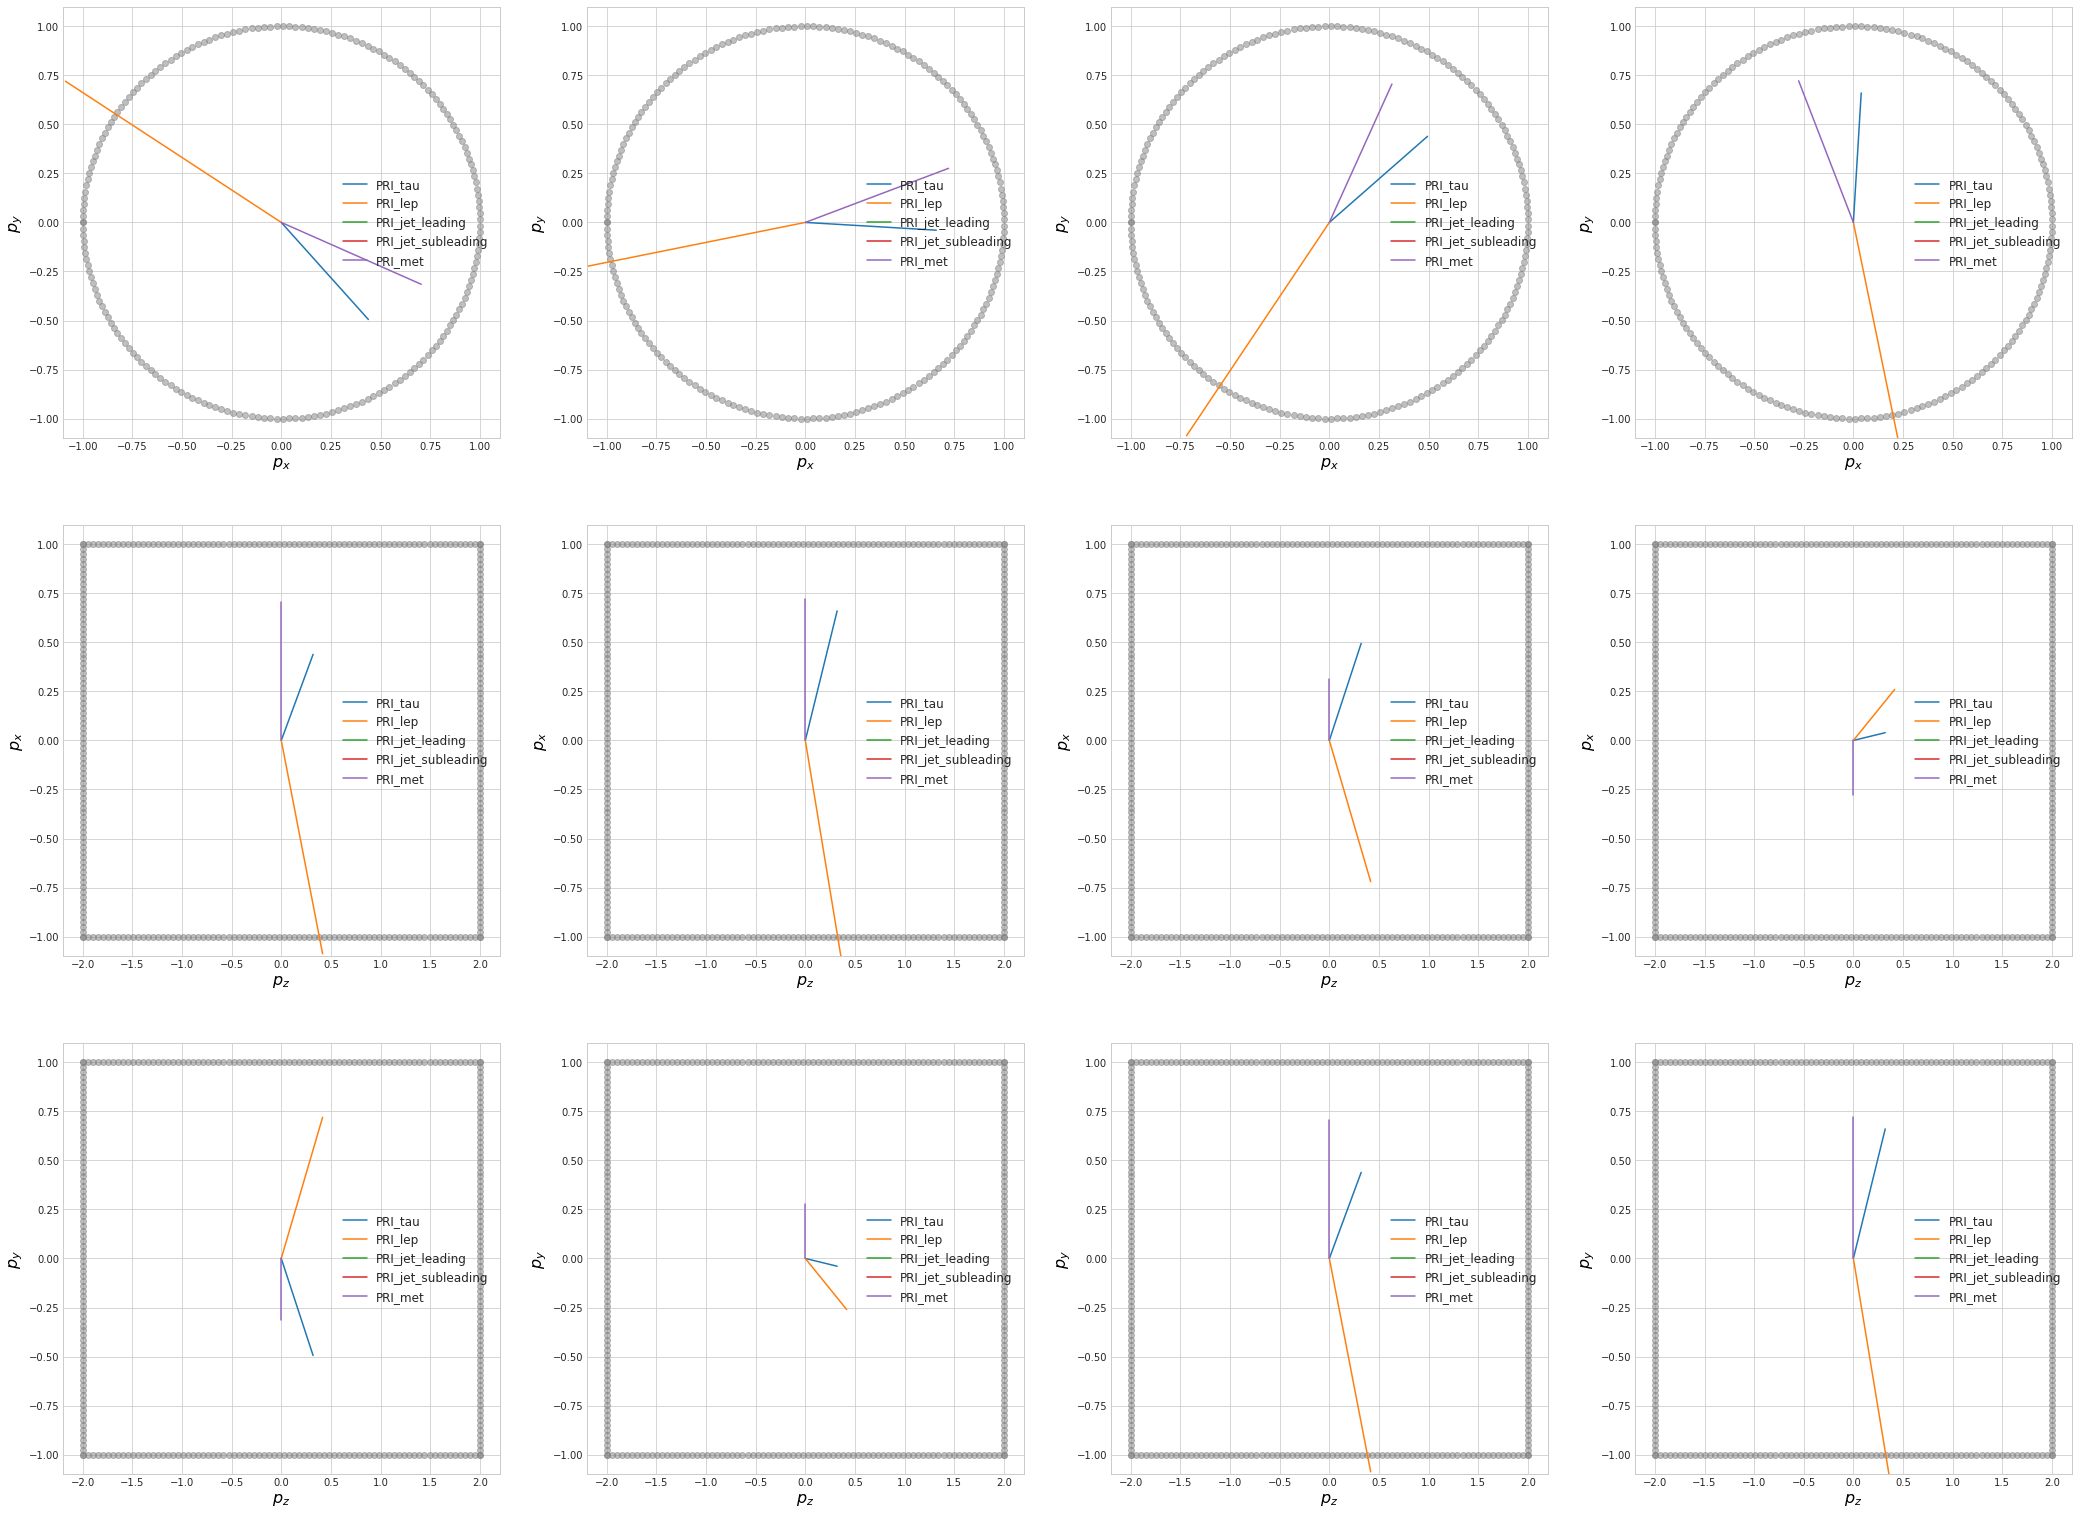

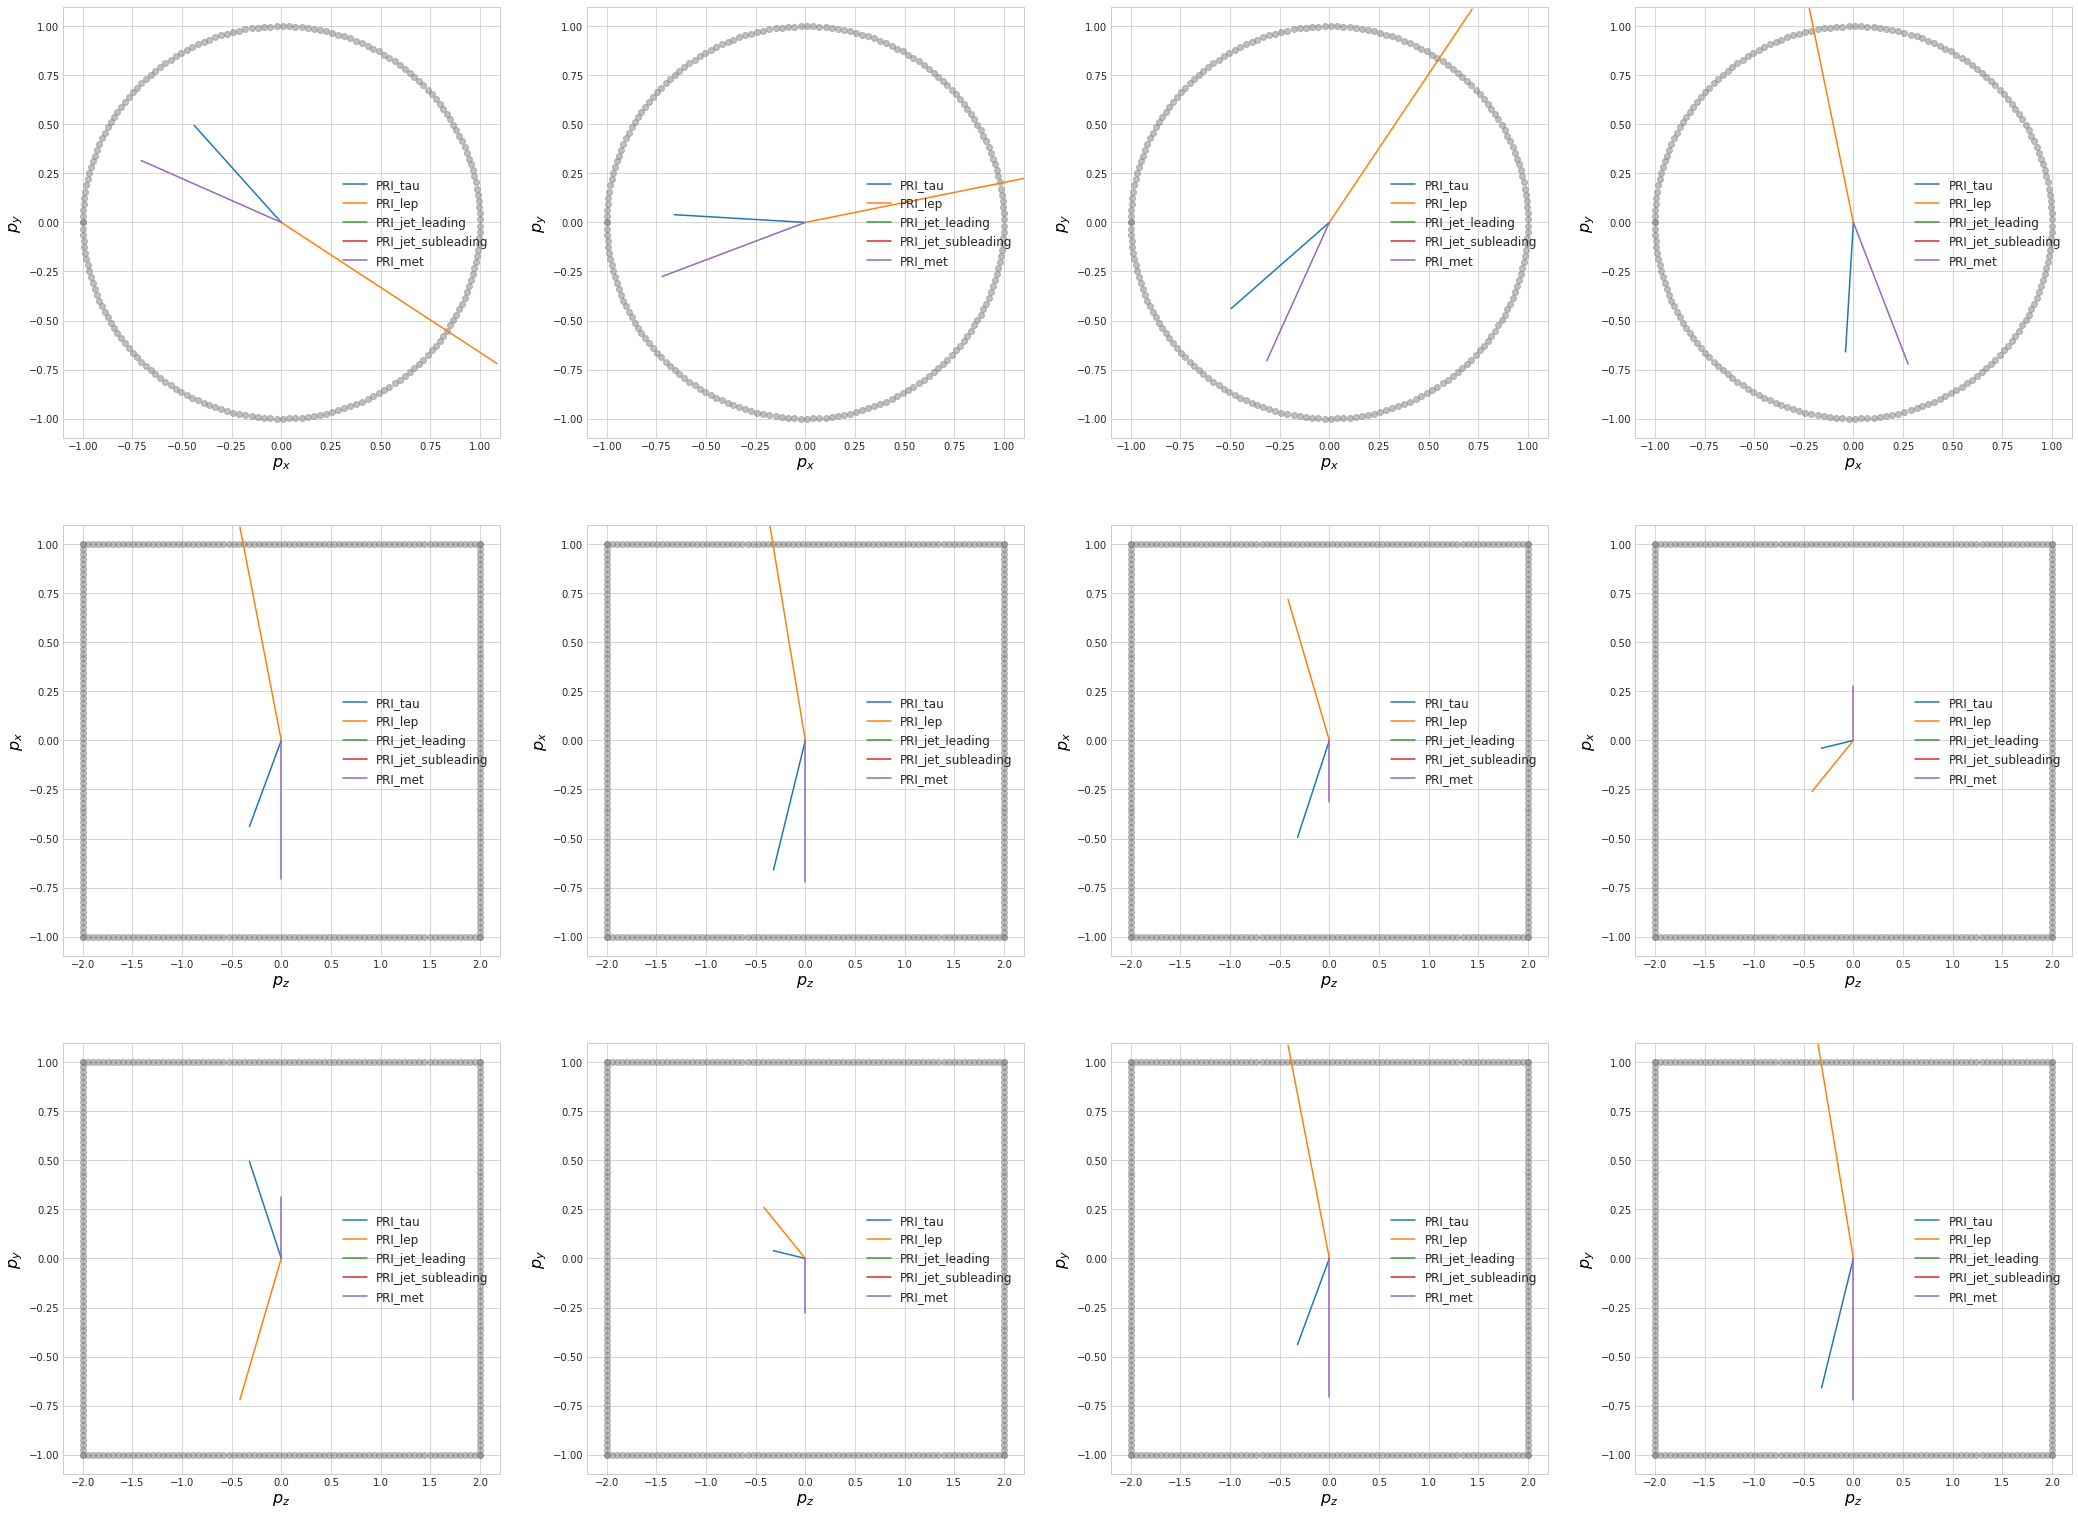

In [5]:
id=3
aug_ranges = [range(4), range(4,8)]
for aug_range in aug_ranges:
    comp_events([pd.DataFrame(train_fy.get_test_fold(0, i)['inputs'], columns=train_feats)[id:id+1] for i in aug_range])

## Determine LR

2 classes found, running in binary mode



/home/giles/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.



______________________________________
Training finished
Cross-validation took 17.172s 


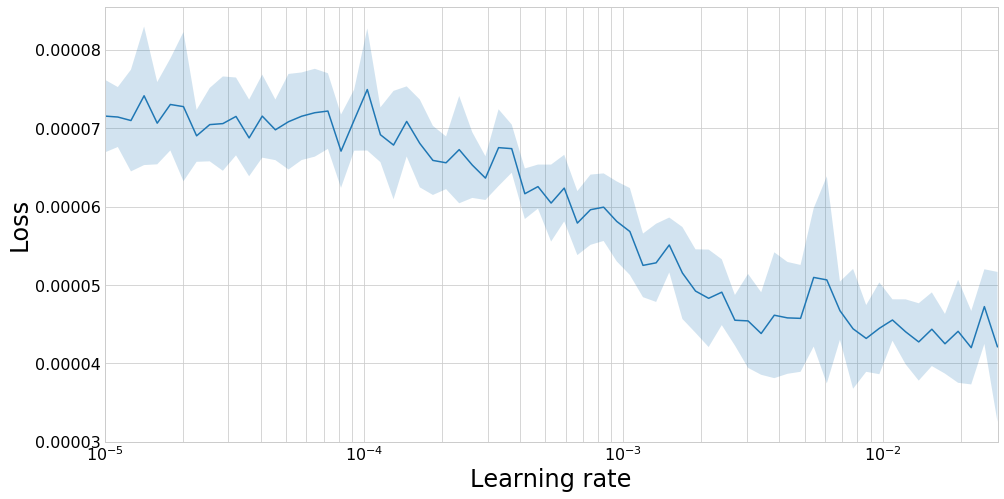

______________________________________



In [6]:
lr_finder = fold_lr_find(train_fy, get_model, model_params, train_params,
                         lr_bounds=[1e-5,1e-1], train_on_weights=True, verbose=0)

## Train classifier

In [7]:
model_gen_params = {**model_params, 'compile_args':{**compile_args, 'lr':2e-3}}
use_callbacks = {'CosAnnealLR':{'cycle_mult':2, 'reverse':False, 'redux_decay':True}}
ams_args = {'n_total':250000, 'br':10, 'delta_b':0}
plots = ['history', 'lr']

Training using weights
Training model 1 / 10
Using cosine LR annealing
2 classes found, running in binary mode



/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100475). Check your callbacks.
  % delta_t_median)


Saving snapshot 1
1 New best found: 3.900340499070307e-05
2 New best found: 3.702841406812577e-05
Saving snapshot 2
3 New best found: 3.6141518963115894e-05
4 New best found: 3.563494792599159e-05
5 New best found: 3.485435255552541e-05
6 New best found: 3.44928517941015e-05
Saving snapshot 3
7 New best found: 3.4349060070328485e-05
11 New best found: 3.4284461810697714e-05
12 New best found: 3.3659668117503214e-05
13 New best found: 3.360528477854274e-05
14 New best found: 3.345570002883519e-05
Saving snapshot 4
15 New best found: 3.3416958696595803e-05
21 New best found: 3.327538792155162e-05
25 New best found: 3.310714408362935e-05
26 New best found: 3.305220797601608e-05
27 New best found: 3.291253205199197e-05
28 New best found: 3.289779702229888e-05
29 New best found: 3.28902525340208e-05
30 New best found: 3.2847302126145735e-05
Saving snapshot 5
31 New best found: 3.283735539889283e-05
48 New best found: 3.2794337514659557e-05
49 New best found: 3.260300568563926e-05
53 New bes

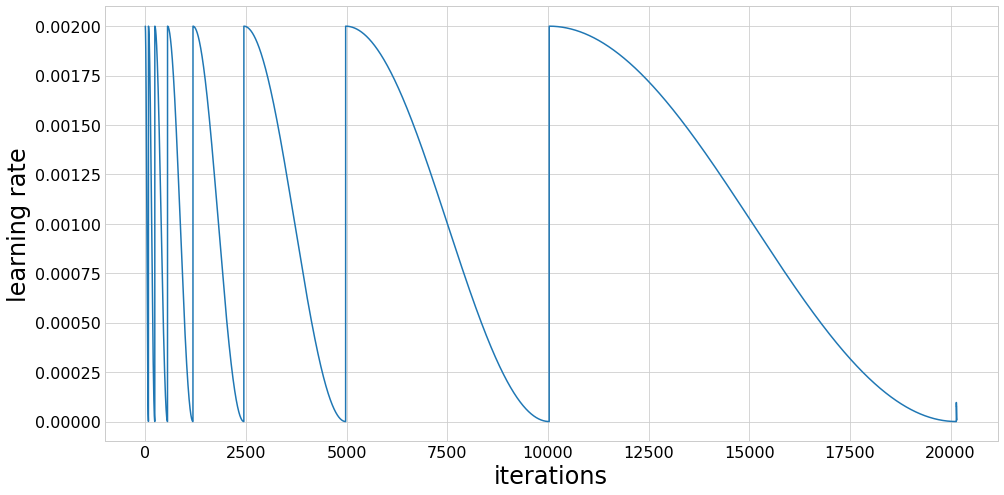

Fold took 247.083s

Training model 2 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105025). Check your callbacks.
  % delta_t_median)


Saving snapshot 1
1 New best found: 3.912650210189598e-05
2 New best found: 3.59678958416587e-05
Saving snapshot 2
3 New best found: 3.5096958662932164e-05
4 New best found: 3.45385200423883e-05
5 New best found: 3.3950005329387626e-05
6 New best found: 3.3520793121224e-05
Saving snapshot 3
7 New best found: 3.333911901663584e-05
11 New best found: 3.318793170761572e-05
12 New best found: 3.304075750868054e-05
13 New best found: 3.2807899086104584e-05
14 New best found: 3.261196920862632e-05
Saving snapshot 4
15 New best found: 3.2610307664369324e-05
23 New best found: 3.2375113377128914e-05
25 New best found: 3.235787441521235e-05
26 New best found: 3.221338599580702e-05
27 New best found: 3.219364405872588e-05
29 New best found: 3.2153856613730356e-05
30 New best found: 3.215101521481877e-05
Saving snapshot 5
31 New best found: 3.2146533596938634e-05
49 New best found: 3.202311562736259e-05
50 New best found: 3.2009707622058515e-05
54 New best found: 3.195861311597907e-05
56 New best

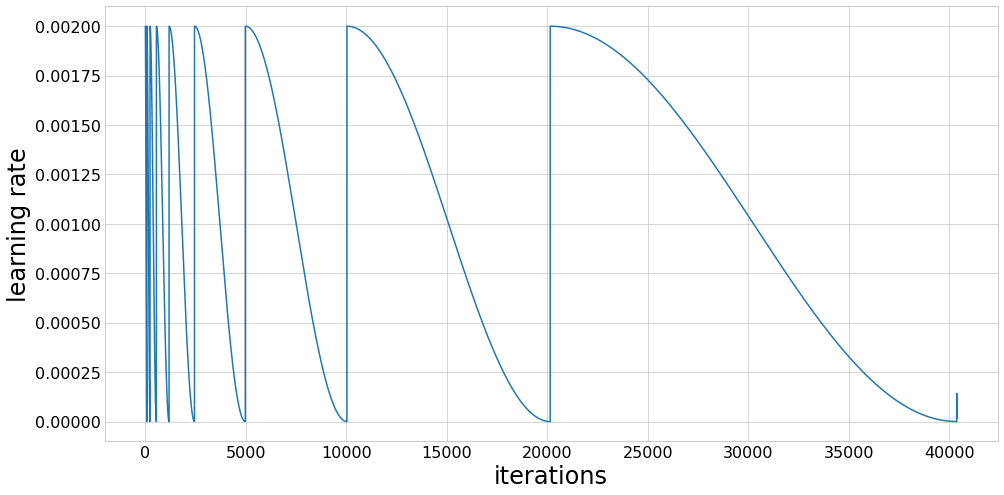

Fold took 489.340s

Training model 3 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232904). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116835). Check your callbacks.
  % delta_t_median)


Saving snapshot 1
1 New best found: 3.938734735467915e-05
2 New best found: 3.710603846447924e-05
Saving snapshot 2
3 New best found: 3.6332081120526546e-05
5 New best found: 3.5345337502505043e-05
6 New best found: 3.477474014640534e-05
Saving snapshot 3
7 New best found: 3.457533937493812e-05
9 New best found: 3.449289874958264e-05
10 New best found: 3.425416457064067e-05
12 New best found: 3.389180050146393e-05
13 New best found: 3.364378158821371e-05
14 New best found: 3.3550537170073975e-05
Saving snapshot 4
22 New best found: 3.343512560169869e-05
23 New best found: 3.326025017155728e-05
25 New best found: 3.298515888467419e-05
27 New best found: 3.2984591864690506e-05
28 New best found: 3.297006918845949e-05
30 New best found: 3.2939553196115283e-05
Saving snapshot 5
31 New best found: 3.2935097047696175e-05
52 New best found: 3.267459856861892e-05
53 New best found: 3.2665394061434816e-05
59 New best found: 3.262095108375885e-05
61 New best found: 3.2609930605894664e-05
Saving 

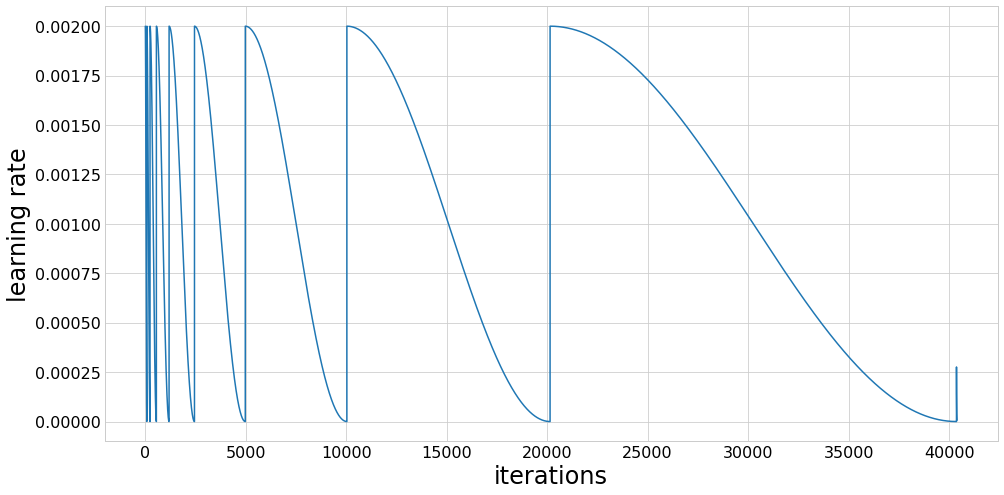

Fold took 509.785s

Training model 4 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250688). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125754). Check your callbacks.
  % delta_t_median)


Saving snapshot 1
1 New best found: 4.022844267165056e-05
2 New best found: 3.6343225344899114e-05
Saving snapshot 2
3 New best found: 3.591805973846931e-05
4 New best found: 3.5661960065772294e-05
5 New best found: 3.5197318812424785e-05
6 New best found: 3.412902919371845e-05
Saving snapshot 3
7 New best found: 3.400506737671094e-05
10 New best found: 3.377764364850009e-05
11 New best found: 3.366880767425755e-05
12 New best found: 3.335927658336004e-05
13 New best found: 3.3063504482561254e-05
14 New best found: 3.2996626636304424e-05
Saving snapshot 4
15 New best found: 3.29863479200867e-05
25 New best found: 3.288312584190862e-05
26 New best found: 3.272801770217484e-05
27 New best found: 3.259263154614018e-05
28 New best found: 3.253694715822348e-05
29 New best found: 3.251358425623039e-05
30 New best found: 3.2484581461176275e-05
Saving snapshot 5
31 New best found: 3.2484037143876776e-05
49 New best found: 3.228724852087907e-05
54 New best found: 3.227890260750428e-05
55 New be

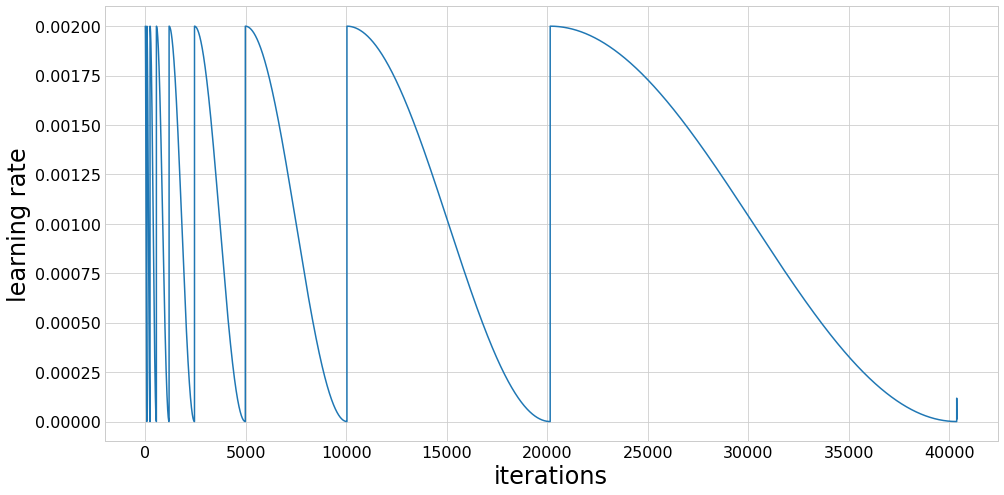

Fold took 517.156s

Training model 5 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.276677). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138778). Check your callbacks.
  % delta_t_median)


Saving snapshot 1
1 New best found: 4.079669132770505e-05
2 New best found: 3.7317771119705865e-05
Saving snapshot 2
3 New best found: 3.609935349086299e-05
4 New best found: 3.524568821885623e-05
5 New best found: 3.501672235142905e-05
6 New best found: 3.451990080793621e-05
Saving snapshot 3
7 New best found: 3.4380172530654815e-05
11 New best found: 3.430268937518122e-05
12 New best found: 3.3746850065654144e-05
13 New best found: 3.348061288997996e-05
14 New best found: 3.338924570562085e-05
Saving snapshot 4
15 New best found: 3.3370242874661925e-05
22 New best found: 3.307917898782762e-05
24 New best found: 3.291422288602916e-05
25 New best found: 3.281560222822009e-05
27 New best found: 3.2758464250946416e-05
28 New best found: 3.266312227060553e-05
29 New best found: 3.263119591138093e-05
30 New best found: 3.259508483315585e-05
Saving snapshot 5
46 New best found: 3.2539731918950565e-05
49 New best found: 3.245118843187811e-05
50 New best found: 3.2400680470163935e-05
54 New b

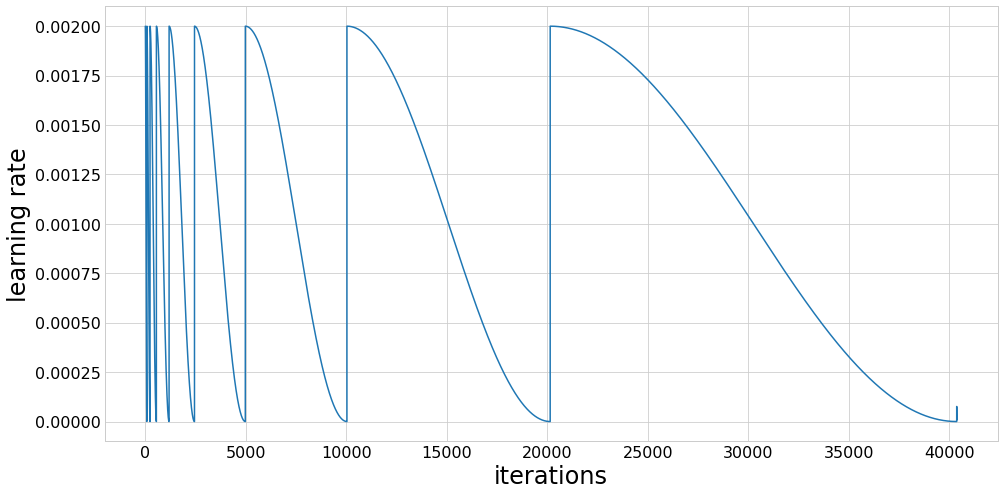

Fold took 531.299s

Training model 6 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.306635). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153699). Check your callbacks.
  % delta_t_median)


Saving snapshot 1
1 New best found: 3.972491576818354e-05
2 New best found: 3.654920887129901e-05
Saving snapshot 2
3 New best found: 3.5738697060923186e-05
5 New best found: 3.445298891592414e-05
6 New best found: 3.420680997739142e-05
Saving snapshot 3
7 New best found: 3.4096084639237344e-05
11 New best found: 3.3898378363081656e-05
12 New best found: 3.382214977732276e-05
13 New best found: 3.349175752449959e-05
14 New best found: 3.338222614255777e-05
Saving snapshot 4
15 New best found: 3.3366820574392634e-05
23 New best found: 3.331147393459694e-05
24 New best found: 3.330098911422954e-05
25 New best found: 3.2941866412655205e-05
28 New best found: 3.284471602397295e-05
29 New best found: 3.282194091978852e-05
30 New best found: 3.275984390344529e-05
Saving snapshot 5
31 New best found: 3.275864246744746e-05
51 New best found: 3.271186538033143e-05
52 New best found: 3.259643998448096e-05
54 New best found: 3.255946492837588e-05
55 New best found: 3.246825745157374e-05
57 New be

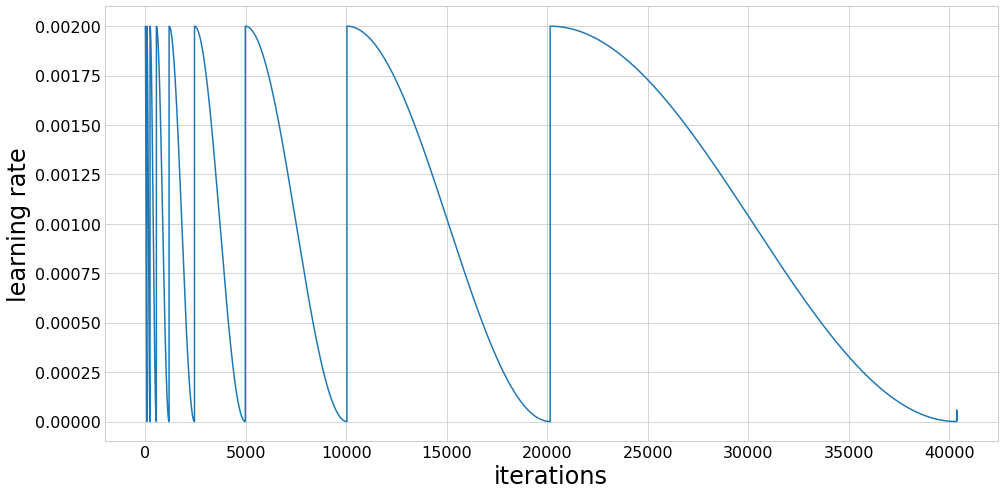

Fold took 537.406s

Training model 7 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.319960). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160342). Check your callbacks.
  % delta_t_median)


Saving snapshot 1
1 New best found: 3.7990030217222896e-05
2 New best found: 3.625202876369968e-05
Saving snapshot 2
3 New best found: 3.5189472903886465e-05
5 New best found: 3.439188975856681e-05
6 New best found: 3.366250607982033e-05
Saving snapshot 3
9 New best found: 3.349539481369332e-05
10 New best found: 3.311943120641976e-05
11 New best found: 3.289509581974701e-05
13 New best found: 3.265470079764912e-05
14 New best found: 3.2504669441459914e-05
Saving snapshot 4
21 New best found: 3.228963319248359e-05
25 New best found: 3.214767376107858e-05
26 New best found: 3.207972100800653e-05
28 New best found: 3.197627316022374e-05
29 New best found: 3.1920470943303654e-05
30 New best found: 3.1912334346756494e-05
Saving snapshot 5
48 New best found: 3.188424284452369e-05
49 New best found: 3.1880366676244116e-05
50 New best found: 3.18438150798535e-05
52 New best found: 3.1822104887866975e-05
53 New best found: 3.17048837691055e-05
55 New best found: 3.166479995360261e-05
56 New be

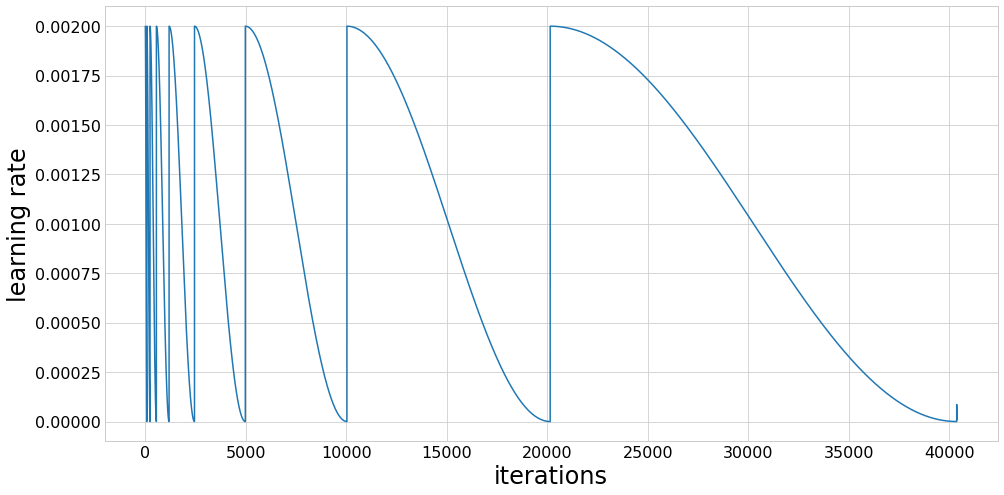

Fold took 546.220s

Training model 8 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.357088). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178936). Check your callbacks.
  % delta_t_median)


Saving snapshot 1
1 New best found: 3.947729850042378e-05
2 New best found: 3.6570214551466055e-05
Saving snapshot 2
3 New best found: 3.583834318560548e-05
4 New best found: 3.574803646770306e-05
5 New best found: 3.4671675923164005e-05
6 New best found: 3.413503686024342e-05
Saving snapshot 3
10 New best found: 3.382372923515504e-05
11 New best found: 3.379256313055521e-05
12 New best found: 3.353446353430627e-05
13 New best found: 3.329692994157085e-05
14 New best found: 3.314169829682214e-05
Saving snapshot 4
15 New best found: 3.307212107029045e-05
22 New best found: 3.304466899571708e-05
23 New best found: 3.293263109808322e-05
24 New best found: 3.2931155737605876e-05
25 New best found: 3.260440730373375e-05
26 New best found: 3.25983869668562e-05
27 New best found: 3.255632057698676e-05
28 New best found: 3.249508262379095e-05
29 New best found: 3.249116537626833e-05
30 New best found: 3.245650021999609e-05
Saving snapshot 5
31 New best found: 3.244851687923074e-05
49 New best 

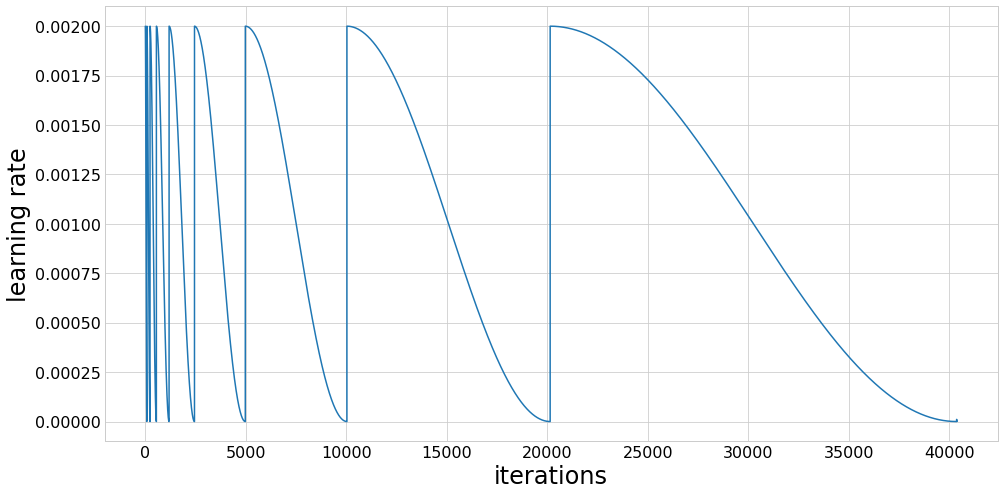

Fold took 559.240s

Training model 9 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.392942). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196860). Check your callbacks.
  % delta_t_median)


Saving snapshot 1
1 New best found: 3.893077623652061e-05
2 New best found: 3.6498510208912196e-05
Saving snapshot 2
3 New best found: 3.587397210212657e-05
4 New best found: 3.516090996999992e-05
5 New best found: 3.468349957111059e-05
6 New best found: 3.4193459639209326e-05
Saving snapshot 3
7 New best found: 3.4121865515771786e-05
11 New best found: 3.371237515093526e-05
12 New best found: 3.356255984981544e-05
13 New best found: 3.344434640894178e-05
14 New best found: 3.3225511232740245e-05
Saving snapshot 4
15 New best found: 3.319702897424577e-05
23 New best found: 3.2925907596654726e-05
26 New best found: 3.282927041291259e-05
27 New best found: 3.278318365046289e-05
28 New best found: 3.269959621684393e-05
29 New best found: 3.269600951753091e-05
30 New best found: 3.266887942736503e-05
Saving snapshot 5
31 New best found: 3.2664956427470314e-05
49 New best found: 3.256717218464473e-05
51 New best found: 3.247158400627086e-05
52 New best found: 3.2432557780703065e-05
54 New b

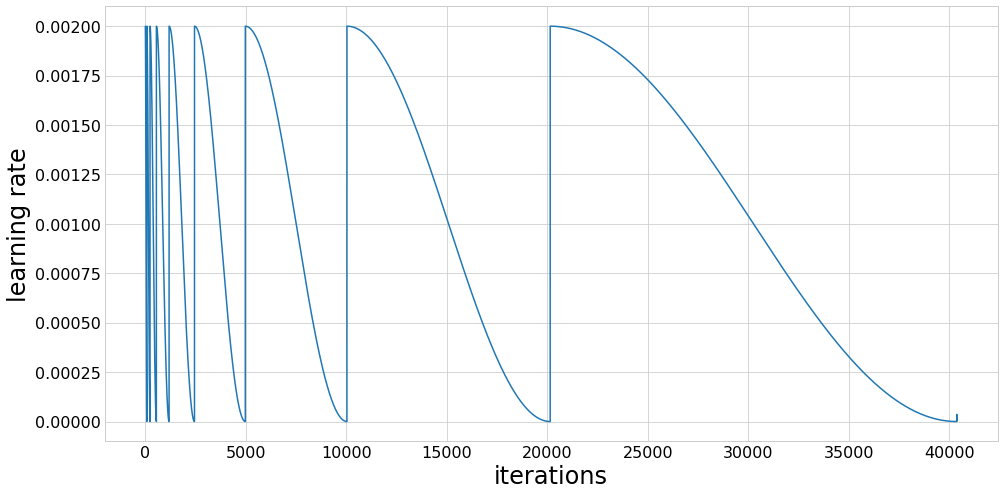

Fold took 572.063s

Training model 10 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.399648). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200275). Check your callbacks.
  % delta_t_median)


Saving snapshot 1
1 New best found: 4.0263728908672086e-05
2 New best found: 3.6591179078771854e-05
Saving snapshot 2
3 New best found: 3.601545578578298e-05
4 New best found: 3.580000693418236e-05
5 New best found: 3.578061840989861e-05
6 New best found: 3.467467829996077e-05
Saving snapshot 3
7 New best found: 3.45972826631886e-05
11 New best found: 3.415627160074048e-05
12 New best found: 3.405506670496046e-05
13 New best found: 3.366157729377136e-05
14 New best found: 3.35510760394859e-05
Saving snapshot 4
15 New best found: 3.352211380333367e-05
21 New best found: 3.351149364075e-05
23 New best found: 3.3387272604179455e-05
24 New best found: 3.3352246759255846e-05
25 New best found: 3.3179374773970553e-05
27 New best found: 3.301655500263835e-05
28 New best found: 3.296706435024074e-05
29 New best found: 3.295431878026122e-05
30 New best found: 3.291293964820613e-05
Saving snapshot 5
46 New best found: 3.2871192360572394e-05
47 New best found: 3.284449532404857e-05
49 New best fo

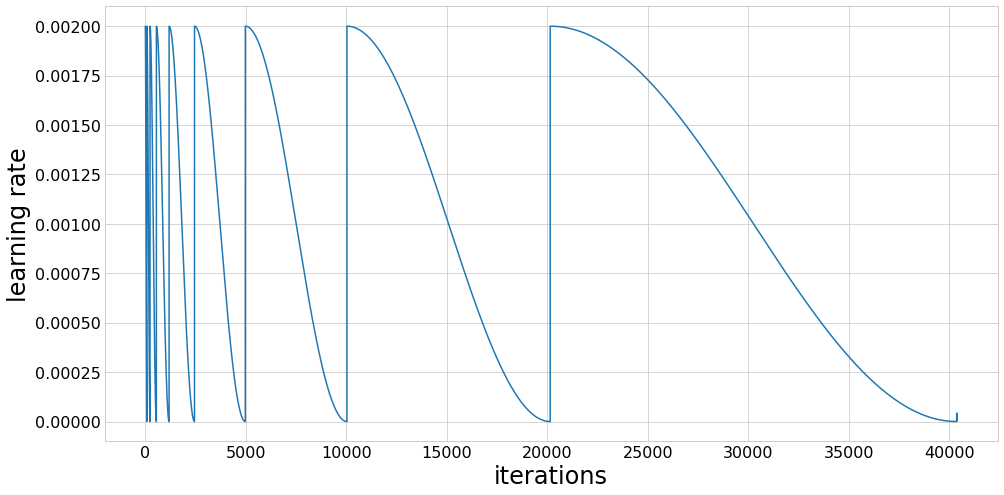

Fold took 580.749s


______________________________________
Training finished
Cross-validation took 5090.538s 


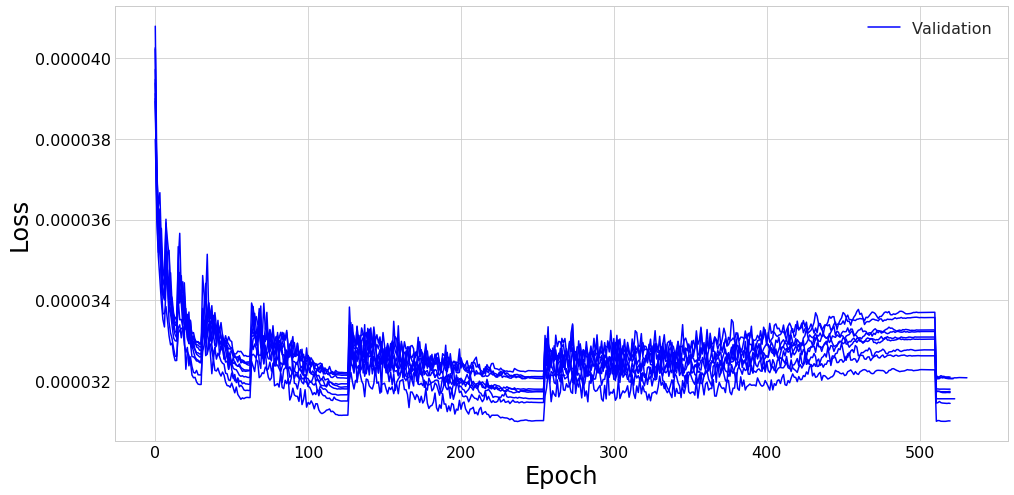

Mean loss = 3.18e-05 +- 1e-07
Mean wAUC = 0.0631 +- 0.0004
Mean AUC = 0.0983 +- 0.0006
Mean AMS = 4.0 +- 0.1
Mean cut = 0.966 +- 0.007
______________________________________



<Figure size 432x288 with 0 Axes>

In [8]:
results, histories, cycle_losses = fold_train_model(train_fy, n_models,
                                                    model_gen_params=model_gen_params,
                                                    train_params=train_params, train_on_weights=True,
                                                    use_callbacks=use_callbacks, ams_args=ams_args,
                                                    max_epochs=max_epochs, patience=patience,
                                                    verbose=1, plots=plots)

## Construct ensemble

In [4]:
with open('train_weights/results_file.pkl', 'rb') as fin:   
    results = pickle.load(fin)
with open('train_weights/cycle_file.pkl', 'rb') as fin:   
    cycle_losses = pickle.load(fin)

In [5]:
ensemble, weights = assemble_ensemble(results, 10, ensemble_mode, compile_args, weighting='reciprocal')


Choosing ensemble by loss
Model 0 is 6 with loss = 3.0993631616472584e-05


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Model 1 is 1 with loss = 3.1438985188934535e-05
Model 2 is 7 with loss = 3.1556390369951256e-05


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Model 3 is 3 with loss = 3.170524727174779e-05
Model 4 is 4 with loss = 3.1719203099783044e-05


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Model 5 is 8 with loss = 3.1792050099465995e-05
Model 6 is 5 with loss = 3.205337081990028e-05


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Model 7 is 2 with loss = 3.206429390245172e-05
Model 8 is 9 with loss = 3.208842967612991e-05
Model 9 is 0 with loss = 3.211724769833852e-05


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [11]:
def test_ensemble(weighting, size, rot_mult):
    ensemble, weights = assemble_ensemble(results, size, ensemble_mode, compile_args, weighting=weighting, verbose=0)
    val_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'val.hdf5', "r+"), rot_mult=rot_mult)
    fold_ensemble_predict(ensemble, weights, val_fy, pred_name='pred_TTA', ensemble_size=ensemble_size, verbose=0)
    val_df_tta = convert_to_df(val_fy.source, pred_name='pred_TTA')
    ams, cut = ams_scan_slow(val_df_tta, br=10, w_factor=250000/50000)
    print(weighting, size, rot_mult, ams, cut)

In [12]:
for weighting in ['reciprocal', 'uniform']:
    for size in [1,3,5,10]:
        for rot_mult in [1,2,4,8,16]:
            print('__________________________________')
            test_ensemble(weighting, size, rot_mult)
            print('__________________________________\n')

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 4
50000 candidates loaded
reciprocal 1 1 3.850784248776697 0.9590704
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8
50000 candidates loaded
reciprocal 1 2 3.905159871874135 0.9582056
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 16
50000 candidates loaded
reciprocal 1 4 3.9503908719499607 0.9596651
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 32
50000 candidates loaded
reciprocal 1 8 3.9538202979068804 0.95965964
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 64
50000 candidates loaded
reciprocal 1 16 3.9702656661356746 0.95922935
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 4
50000 candidates loaded
reciprocal 3 1 3.9166386576706693 0.959035
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8
50000 candidates loaded
reciprocal 3 2 3.92783162287057 0.95942175
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 16
50000 candidates loaded
reciprocal 3 4 3.9244204376167406 0.9588755
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 32
50000 candidates loaded
reciprocal 3 8 3.9193415320552343 0.958969
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 64
50000 candidates loaded
reciprocal 3 16 3.924385681290142 0.95934886
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in s

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 4
50000 candidates loaded
reciprocal 5 1 3.932193923254032 0.95704085
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in s

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8
50000 candidates loaded
reciprocal 5 2 3.950846349767887 0.9598899
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in s

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 16
50000 candidates loaded
reciprocal 5 4 3.93143293136858 0.9599277
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in s

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 32
50000 candidates loaded
reciprocal 5 8 3.9368286956933054 0.9597833
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in s

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 64
50000 candidates loaded
reciprocal 5 16 3.924853618816857 0.960069
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in s

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 4
50000 candidates loaded
reciprocal 10 1 3.9594150889269883 0.96130615
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in s

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8
50000 candidates loaded
reciprocal 10 2 3.9435894321983427 0.9605126
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in s

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 16
50000 candidates loaded
reciprocal 10 4 3.9432394731455713 0.9587486
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in s

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 32
50000 candidates loaded
reciprocal 10 8 3.9356775161271136 0.9587857
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in s

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 64
50000 candidates loaded
reciprocal 10 16 3.9325839715515873 0.9589145
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 4
50000 candidates loaded
uniform 1 1 3.850784248776697 0.9590704
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8
50000 candidates loaded
uniform 1 2 3.905159871874135 0.9582056
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 16
50000 candidates loaded
uniform 1 4 3.9503908719499607 0.9596651
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 32
50000 candidates loaded
uniform 1 8 3.9538202979068804 0.95965964
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 64
50000 candidates loaded
uniform 1 16 3.9702656661356746 0.95922935
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 4
50000 candidates loaded
uniform 3 1 3.9147553242664315 0.9590583
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8
50000 candidates loaded
uniform 3 2 3.92888048341842 0.9594141
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 16
50000 candidates loaded
uniform 3 4 3.922472516266138 0.9598855
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 32
50000 candidates loaded
uniform 3 8 3.9178465881723534 0.96000683
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 64
50000 candidates loaded
uniform 3 16 3.923275292041229 0.9593259
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in s

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 4
50000 candidates loaded
uniform 5 1 3.930153529681146 0.9588799
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in s

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8
50000 candidates loaded
uniform 5 2 3.950689032834161 0.959887
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in s

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 16
50000 candidates loaded
uniform 5 4 3.9311200526420715 0.9599258
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in s

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 32
50000 candidates loaded
uniform 5 8 3.9365157891249476 0.95983636
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in s

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 64
50000 candidates loaded
uniform 5 16 3.925166202779157 0.96006894
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in s

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 4
50000 candidates loaded
uniform 10 1 3.9587923707202206 0.96107954
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in s

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8
50000 candidates loaded
uniform 10 2 3.940779663167536 0.9605366
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in s

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 16
50000 candidates loaded
uniform 10 4 3.940328985099216 0.95878166
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in s

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 32
50000 candidates loaded
uniform 10 8 3.9336422393434307 0.9588144
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in s

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 64
50000 candidates loaded
uniform 10 16 3.9280478831900223 0.95893544
__________________________________



## Response on validation data without TTA

In [ ]:
val_fy = FoldYielder(h5py.File(DATA_PATH/'val.hdf5', "r+"))

In [ ]:
fold_ensemble_predict(ensemble, weights, val_fy, ensemble_size=ensemble_size, verbose=1)

In [ ]:
val_df = convert_to_df(val_fy.source)

In [ ]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(val_df.gen_target, val_df.pred_class),
                                                           roc_auc_score(val_df.gen_target, val_df.pred_class, sample_weight=val_df.gen_weight)))

In [ ]:
%%time
cut_kde = kde_optimise_cut(val_df, top_perc=0.05, br=10, w_factor=250000/50000)

In [ ]:
%%time
cut_mean = mean_optimise_cut(val_df, top_perc=0.05, br=10, w_factor=250000/50000)

## Response on validation data with TTA

In [16]:
val_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'val.hdf5', "r+"), rot_mult=3, random_rot=True)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 12


In [17]:
fold_ensemble_predict(ensemble, weights, val_fy, pred_name='pred_TTA', ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.001756220144405961s per sample

Predicting fold 2 out of 10
Prediction took 0.0017657881602644921s per sample

Predicting fold 3 out of 10
Prediction took 0.0017545731641352177s per sample

Predicting fold 4 out of 10
Prediction took 0.0017019284289330244s per sample

Predicting fold 5 out of 10
Prediction took 0.0017534457992762326s per sample

Predicting fold 6 out of 10
Prediction took 0.0017412141017615795s per sample

Predicting fold 7 out of 10
Prediction took 0.0017316460121423005s per sample

Predicting fold 8 out of 10
Prediction took 0.0017288749862462282s per sample

Predicting fold 9 out of 10
Prediction took 0.0017241188529878856s per sample

Predicting fold 10 out of 10
Prediction took 0.0017599559925496578s per sample



In [18]:
val_df_tta = convert_to_df(val_fy.source, pred_name='pred_TTA')

50000 candidates loaded


In [19]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(val_df_tta.gen_target, val_df_tta.pred_class),
                                                           roc_auc_score(val_df_tta.gen_target, val_df_tta.pred_class, sample_weight=val_df_tta.gen_weight)))

Testing ROC AUC: unweighted 0.9039934808300911, weighted 0.9362915773069778


Best cut at 0.9608800032952646 corresponds to AMS of 3.8877481801278955
Maximum AMS for data is 3.932952948014832 at cut of 0.9587390422821045
CPU times: user 24.9 s, sys: 0 ns, total: 24.9 s
Wall time: 24.9 s


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


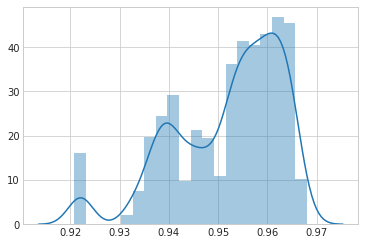

In [20]:
%%time
cut_kde_tta = kde_optimise_cut(val_df_tta, top_perc=0.05, br=10, w_factor=250000/50000)

Mean cut at 0.9519579 corresponds to AMS of 3.8110668320120324
Maximum AMS for data is 3.932952948014832 at cut of 0.9587390422821045
CPU times: user 103 ms, sys: 34.6 ms, total: 138 ms
Wall time: 94.4 ms


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


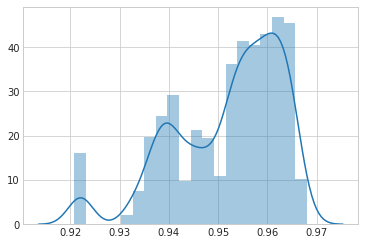

In [21]:
%%time
cut_mean_tta = mean_optimise_cut(val_df_tta, top_perc=0.05, br=10, w_factor=250000/50000)

# Test scoring - Without TTA

In [ ]:
test_fy = FoldYielder(h5py.File(DATA_PATH/'testing.hdf5', "r+"))

In [ ]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, ensemble_size=ensemble_size, verbose=1)

In [ ]:
score_test_data(test_fy.source, cut_kde)

In [ ]:
score_test_data(test_fy.source, cut_mean)

# Test scoring - With TTA

In [22]:
test_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'testing.hdf5', "r+"),
                            rot_mult=3, random_rot=True)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 12


In [ ]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, pred_name='pred_TTA', ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0015995102373713797s per sample

Predicting fold 2 out of 10
Prediction took 0.0015758601510389284s per sample

Predicting fold 3 out of 10
Prediction took 0.0015718028522689234s per sample

Predicting fold 4 out of 10


In [ ]:
score_test_data(test_fy.source, cut_kde_tta, pred_name='pred_TTA')

In [ ]:
score_test_data(test_fy.source, cut_mean_tta, pred_name='pred_TTA')

# Save/Load

In [ ]:
name = "weights/Swish_CLR_TTA"

In [ ]:
saveEnsemble(name, ensemble, weights, compile_args, overwrite=1)

In [ ]:
ensemble, weights, compile_args, _, _ = loadEnsemble(name)